# Intro

Welcome to CheRMiT! This notebook will teach you about the various procedures that are employed in our project's pipeline. We hope you have a great time completing it.

-Bryan and Max

# Context

The iGEM wetlab teams are performing experiments to test the efficacies of different promoter sequences, and are using the GFP gene as a measure of gene expression. Although GFP is a well-validated and well-performing fluorescent protein, it has some disadvantages and alternative compounds could yield better results for colorimetric assays.

We are going to perform some computational experiments on lycopene, a flourescent compound that is a precursor to the orange-colored carotene.

# Data Collection

The first part of our project consists of collecting data

PMID: 11673627
29276501

design a script that,

SETUP NOTEBOOK

Pseudocode:
- RDKit
- API to fetch papers?
- ChemTagger?
- Snorkel?
- PyTorch + train a small ML model?

If it's all in colab, do we even need a setup notebook?


Primary goal: make sure new and old members know the ins and outs of all aspects of the project

Reading papers
How to use cheminformatics software
Annotating paper (manual, and automatic!)
Fetch the paper using an API
Secondary objective: Connecting project to wetlab component

Wetlab is engineering better promoter-terminator pairs (regulatory units that control a gene)

Output: colorimetric observation of the gene that is involved in production of carotene

Using our tools to probe this reaction of interest, find reaction data from papers!

Explore potential alternative byproducts w/ reaction operators

Standalone component that's all in Java. Could be a bit annoying for us, but would helpf a lot with streamlining future members training and setup.

Use RDKit, stick to a few logical operators, and produce the resultant products!


# RDKit and Reaction Verification

This section will now transition to how we can verify reactions have occurred. To begin, we'll install conda, a Python package management utility, by running the following. The kernel will automatically restart after downloading.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

To verify we've installed conda successfully, we'll run this command. You should see something like "conda 4.14.0" appear.

In [ ]:
!conda --version

Now, we'll install the packages we need. RDKit is a library containing our chemical reaction-associated code. nb_conda is a collection of conda utilities adapted for use on Jupyter Notebooks, like this one.

In [ ]:
!conda install -c rdkit rdkit
!conda install nb_conda

Now, after we've installed what we need, we can setup a conda *environment*. This will be the "sandbox" in which we operate and use the package of interest.

In [ ]:
!conda create -c rdkit -n my-rdkit-env rdkit

Next, we'll activate the environment with this handy little script.

In [ ]:
%%bash
source activate my-rdkit-env

Finally, let's make sure that our rdkit is properly set up and working. If this works, then we should be able to see the output as "[(0, 'R')]".


In [ ]:
from rdkit import Chem
mol = Chem.MolFromSmiles('[C@H](Cl)(F)Br')
Chem.FindMolChiralCenters(mol)

Great! We're ready to get started with the RDKit code itself. So, we can see that there's a function MolFromSmiles. This function is taking in a SMILES formatted string, which represents a molecule, and outputting a Molecule object(this isn't as immediately obvious in Python, a dynamically typed language). 

We need to be able to represent molecules in a way, and SMILES is one out of many ways to be able to represent the structure of molecules. Luckily, there are many ways to do this, SMILES is only one of them. We also work with InChIs.

Here, we'll be able to see the ability of chemical structure representation in action! 

In [ ]:
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
# Create mol object from smiles string
mol = Chem.MolFromSmiles('c1cccnc1O') #this is a smiles object
molSize=(450,150)
mc = Chem.Mol(mol.ToBinary())
if not mc.GetNumConformers():
#Compute 2D coordinates
  rdDepictor.Compute2DCoords(mc)
# init the drawer with the size
drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
#draw the molcule
drawer.DrawMolecule(mc)
drawer.FinishDrawing()
# get the SVG string
svg = drawer.GetDrawingText()
# fix the svg string and display it
display(SVG(svg.replace('svg:','')))

Beautiful! We should be seeing a nice molecule getting drawn on the screen. Aren't libraries so awesome?

One of the core skills of a programmer is to know your code, especially the library that you're using. The RDKit documentation can be found here: https://www.rdkit.org/docs/source/rdkit.html 

Take a look, and keep this handy, since you will need to consult this in order to write functions.

# Pathway Pathfinding

The synthesis of lycopene will be a useful marker for measuring gene activity, especially that of a promoter which controls synthesis of this gene.

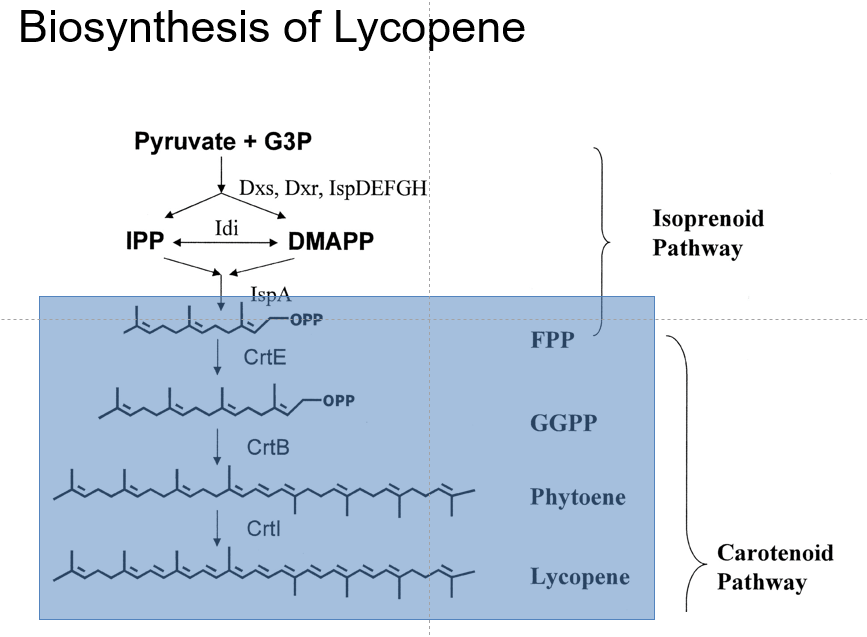

The end result of this pathway looks a bit like this:

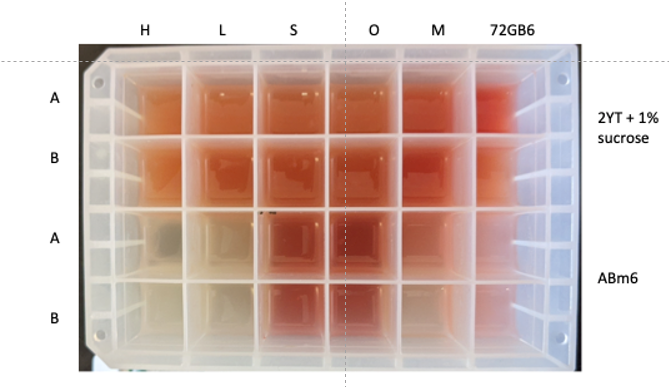

As we can see, the familiar red color of tomatoes is actually due to lycopene, which can easily be used to quantify via a spectrometer to see how active these promoters are. In the interest of discovering what exactly is going on, we'll take a look at the individual reactions.

To start us off, we'll read this article for a overview of this process. 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5727423/

**Reading Articles**

Not only is learning to read articles an important part of CHeRMiT, but it's also an important part of becoming a scientist in general. To be able to effectively parse articles(not only to extract the relevant sentences but also to understand the key point and the purpose of experiments and what they demonstrate) is an invaluable skill that will help you in everything from writing concisely and clearly to being able to understand documentation from the first readthrough.

As you read through this article, take note of the following relevant to text processing for your own reference:

1) Where are the chemical reactions typically located within the text?

2) How are these chemical reactions typically described? What words are used?

3) Are there any "cluttering" chemicals that are't related to the relevant reactions? How would we sort these out, or do we want to sort them out at all?

Phew! What a dense paper. There's definitely a lot of chemical reactions that are contained, both chemical on chemical and enzyme mediated. That's a ton of information to be able to process--let's think about we can convert the relevant chemical names that we've extracted from the paper to something that our processing pipeline can understand. To do this, we'll use PubChem to search for the English name of a molecule, and output the structural formula in an format understandable to our program. PubChemPy is a wrapper for the PubChem REST API, and the documentation for your reference can be found here: https://pypi.org/project/PubChemPy/1.0/

This wrapper makes it much easier to work with data, without having to worry too much about the actual formatting that the REST API wants to accept data in. (Why worry about if your query is in valid XML format when all you want to find a chemical?)

In [ ]:
!conda install -c mcs07 pubchempy


Let's make sure we installed this correctly! Run the following to see if we're obtaining what we want.

In [ ]:
import pubchempy as pcp
results = pcp.get_compounds('Glucose', 'name')
print(results)

Cool! It seems we've obtained a compound object, with a number. How mysterious! Let's take a look in the documentation to see what we can learn from this. What does it represent? How can we take this object and extract a chemical structure(SMILES or InChI) from this?

Hint: there's no shame in writing code based off code that works. Take the code above and see if there's a property of the {Compound} class contains that we can search through to get what we want. 

P.S. You can always ask for help! The real world is a collaborative place, and people are always willing to lend a hand. Just message the Slack channel!

In [ ]:
results = pcp.get_compounds('Glucose', 'name')

#your code here

print(smiles_or_inchi)

Now that we've been able to successfully output the representation of the molecule in a chemically valid form, let's take a look at how RDKit can let us use what are known as Reaction Operators(or ROs for short) to perform a reaction using a string in SMILES. Here's some example code for us to examine.

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
rxn = rdChemReactions.ReactionFromSmarts('[C:1](=[O:2])O.[N:3]>>[C:1](=[O:2])[N:3]') #this is a reaction operator
reacts = (Chem.MolFromSmiles('C(=O)O'),Chem.MolFromSmiles('CNC'))
products = rxn.RunReactants(reacts)
Chem.MolToSmiles(products[0][0]) #it's a good idea to find out what exactly products is/what the len is
#what does the size of products mean? what does it physically mean if it's larger than 1?

Now that we've been introduced to the syntax of how we can use ROs, and standardized reactants, as well as some tools to convert between English names and standardized forms, we are now ready to do some real, never-done-before cheminformatics work.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #this will ask for access to your drive, hit yes
with open('/content/drive/My Drive/Colab Notebooks/2015_01_16-ROPruner_hchERO_list.txt', 'r') as f: #depending on where this notebook is, you may need to change the filepath
    print(f.read())

OK! We should be seeing a sizeable output of a file with a bunch of names and output. Do you see the ROs contained within here? 

Now, it's time to take all these canonical known ROs and store them in a way we can access. The implementation is up to you: whether a dataframe, dictionary, etc. However, since Snorkel data will likely be piped in via a dataframe, it might be advantageous to be familiar with it.

In [ ]:
#your code to read ROs specifically goes here
#note: the ROs are separated from the other columns by a space separator character-maybe this could be helpful when reading strings

#Implement it yourself

Once we've done this successfully, we have all the tools we need to implement our own chemical reaction validator! Here is the spec for what needs to be implemented by you!


**Step 1**

Find an article relating to a biosynthetic pathway. It doesn't need to be regarding lycopene synthesis--it can be regarding any biosynthetic pathway or reaction. In fact, the more representative of the average paper the better to show that this works for all papers.

**Step 2**

This step depends on the text processing half of the notebook. We will either manually curate the body of the text, or use the function we wrote in the earlier part of the notebook to extract relevant words.

**Step 3**

After we have extracted relevant words, we will need to convert them to a form recognizable by RDKit. Here, we will use PubChem to search for(successfully or unsuccessfully)a SMILES or InChI string for given names.

**Step 4**

Once we have a list of molecules, we can move to reacting them with the assemblage of reaction operators that have been curated. Combinatorially react these to see if we have a successful match of SMILES or InChIs to another structure within our list of extracted chemical structures--perhaps this indicates a successful reaction pair?

You have a lot of flexibility with how you implement this code! What exactly you do is up to you, **and as always, feel free to ask questions and share amongst each other. It's a group effort!**

**Step 5-Parting thoughts**

In this notebook, we've focused on one paper of your choice. How would you cope with parsing a database's worth of papers? Are there any efficiency considerations to optimize? What about the possibility of differing formats causing issues? What about scanned papers containing typos or mis-OCR'ed characters?

One of the worst things to work through is poorly documented code. You've used plenty of other people's code in the form of imports in this project and beyond, and without knowing anything about the actual source code, we were able to effectively blackbox it with documentation telling us everything we need to know about which function does what, takes what function calls, and expected behavior. *Make it easier on the future you and other people-document your code as well as you can!*

Notes: we can use our hand annotations for validating the validator. Then we can have the papers the everyone uses be relevant to a reaction with GGPP.